In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 

In [7]:
# plt.style.use('seaborn-whitegrid')

In [12]:
df=pd.read_csv('../data/companies.csv')
df.shape

(196553, 44)

In [13]:
def clean_funding(x):
    if pd.isna(x):
        return np.nan
    try:
        return float(x)
    except:
        return np.nan

In [14]:
df.columns

Index(['id', 'Unnamed: 0.1', 'entity_type', 'entity_id', 'parent_id', 'name',
       'normalized_name', 'permalink', 'category_code', 'status', 'founded_at',
       'closed_at', 'domain', 'homepage_url', 'twitter_username', 'logo_url',
       'logo_width', 'logo_height', 'short_description', 'description',
       'overview', 'tag_list', 'country_code', 'state_code', 'city', 'region',
       'first_investment_at', 'last_investment_at', 'investment_rounds',
       'invested_companies', 'first_funding_at', 'last_funding_at',
       'funding_rounds', 'funding_total_usd', 'first_milestone_at',
       'last_milestone_at', 'milestones', 'relationships', 'created_by',
       'created_at', 'updated_at', 'lat', 'lng', 'ROI'],
      dtype='object')

In [18]:
df['total_funding']=df['funding_total_usd'].apply(clean_funding)

print(df['total_funding'].isna().sum())
print(df['total_funding'].describe())

168679
count    2.787400e+04
mean     1.481652e+07
std      6.775937e+07
min      2.910000e+02
25%      5.000000e+05
50%      2.564500e+06
75%      1.100000e+07
max      5.700000e+09
Name: total_funding, dtype: float64


In [19]:
def parse_date(x):
    if pd.isna(x):
        return np.nan
    try:
        return pd.to_datetime(x)
    except:
        return np.nan

In [20]:
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
for col in date_columns:
    df[col] = df[col].apply(parse_date)


In [21]:
df[date_columns].head()

,founded_at,first_funding_at,last_funding_at,closed_at
0,2005-10-17,2005-10-01,2008-05-19,NaT
1,NaT,NaT,NaT,NaT
2,NaT,NaT,NaT,NaT
3,2008-07-26,NaT,NaT,NaT
4,2008-07-26,NaT,NaT,NaT


In [24]:
today=pd.to_datetime('today')
print(today)

2025-11-23 02:45:32.881451


In [34]:
df['company_age_years']=((today - df['founded_at']).dt.days)/365.25
df['company_age_years'].head()
print(df['company_age_years'].isna().sum())
df['company_age_years']= df['company_age_years'].fillna(0)
print(df['company_age_years'].isna().sum())


105326
0


In [35]:
df["time_to_first_funding_days"] = (
    (df["first_funding_at"] - df["founded_at"]).dt.days
)
print(df['time_to_first_funding_days'].isna().sum())
df["time_to_first_funding_days"]=df["time_to_first_funding_days"].fillna(-1)
print(df['time_to_first_funding_days'].isna().sum())

172252
0


In [36]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text=str(text).lower()
    text=re.sub(r'[^a-z0-9\s]', '', text)
    text=re.sub(r'\s+', ' ', text).strip()
    return text
for col in ['short_description', 'overview', 'tag_list', 'market', 'description']:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)



In [40]:
def build_full_text(row):
    name = row.get('name', '')
    desc=row.get('description', '')
    overview=row.get('overview', '')
    tags=row.get('tag_list', '')
    loc= f"{row.get('city', '')} {row.get('region', '')} {row.get('country_code', '')}"
    return f"{name}. {desc}. {overview}. Tags: {tags}. Location: {loc}"

df['full_text'] = df.apply(build_full_text, axis=1)
df['full_text'].head()

0    Wetpaint. technology platform company. wetpain...
1    Flektor. . flektor is a richmedia mashup platf...
2    There. . therecom is an online virtual world w...
3    MYWEBBO. . brand new online social networking ...
4    THE Movie Streamer. . this company shows free ...
Name: full_text, dtype: object

In [41]:
SUCCESS_FUNDING_THRESHOLD = 1_000_000
SUCCESS_ROUNDS_THRESHOLD = 3
positive_cases = {'ipo', 'acquired'}
def success_label(row):
    status =str(row.get('status', '')).lower().strip()
    if status in positive_cases:
        return 1
    if row.get('total_funding', 0) >= SUCCESS_FUNDING_THRESHOLD:
        return 1
    if row.get('funding_rounds', 0) >= SUCCESS_ROUNDS_THRESHOLD:
        return 1
    return 0
df['success_label'] = df.apply(success_label, axis=1)
df['success_label'].value_counts()

success_label
0    169412
1     27141
Name: count, dtype: int64

In [44]:
df['category_code'].isna().sum()

np.int64(73367)

In [47]:
for col in ['total_funding', 'funding_rounds','milestones','relationships']:
    if col in df.columns:
        df[f'log1p_{col}']=np.log1p(df[col].fillna(0))
df['primary_category']=df['category_code'].fillna('unknown')
df['primary_category']=df['primary_category'].apply(lambda x: str(x).split('|')[0])
df['primary_category'].value_counts()

primary_category
unknown             73367
software            17922
web                 15118
other               13617
ecommerce            9065
games_video          7520
mobile               6862
advertising          6098
consulting           5006
enterprise           4441
biotech              4430
hardware             2951
education            2901
public_relations     2846
network_hosting      2350
search               2182
cleantech            1940
health               1698
finance              1386
social               1310
security             1171
medical              1153
analytics            1022
legal                1012
travel                936
local                 785
news                  768
hospitality           768
semiconductor         696
manufacturing         680
sports                675
music                 581
fashion               563
photo_video           544
transportation        489
real_estate           474
messaging             296
automotive           

In [48]:
df.to_csv('../data/processed_company_data.csv', index=False, encoding='utf-8')

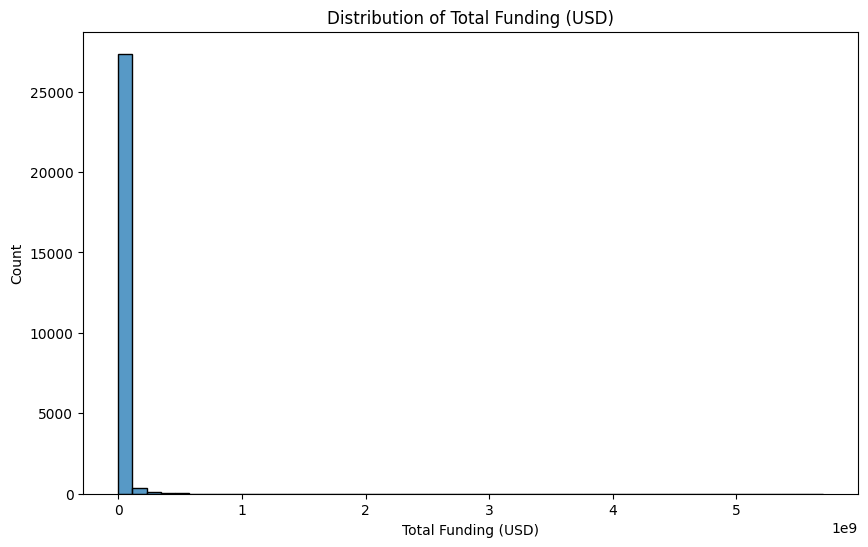

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['total_funding'].dropna(), bins=50)
plt.title('Distribution of Total Funding (USD)')
plt.xlabel('Total Funding (USD)')
plt.savefig('../plots/total_funding_distribution.png')
plt.show()

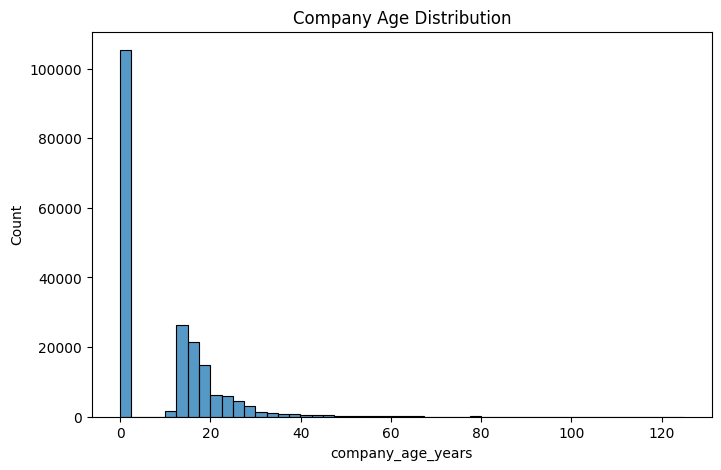

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["company_age_years"], bins=50)
plt.title("Company Age Distribution")
plt.savefig("../plots/company_age_distribution.png")
plt.show()

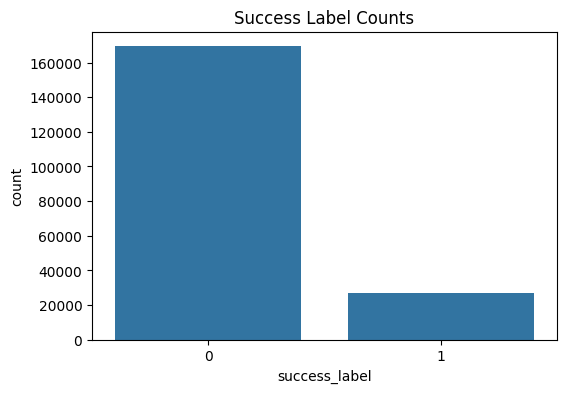

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="success_label", data=df)
plt.title("Success Label Counts")
plt.savefig("../plots/success_label_counts.png")
plt.show()


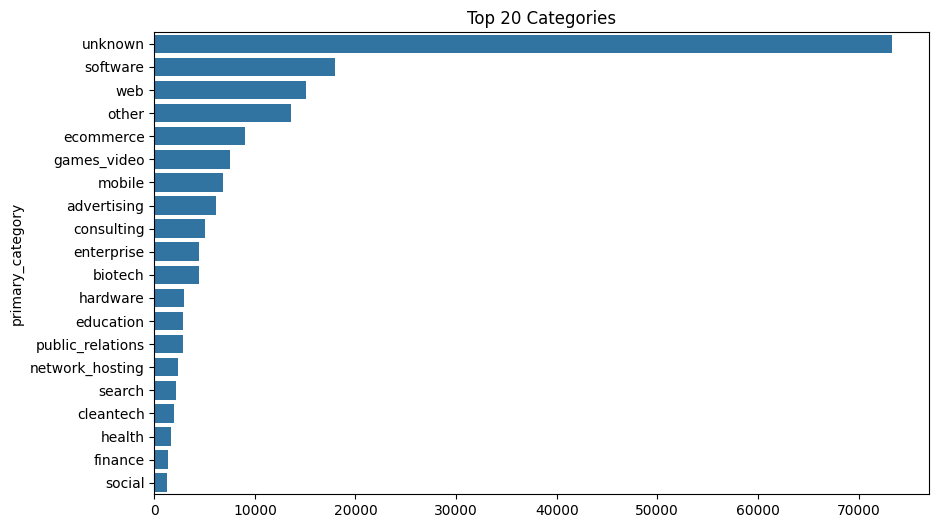

In [ ]:
plt.figure(figsize=(10,6))
top_cat = df["primary_category"].value_counts().head(20)
sns.barplot(x=top_cat.values, y=top_cat.index)
plt.title("Top 20 Categories")
plt.savefig("../plots/top_categories.png")
plt.show()


In [54]:
print("\nEDA Completed Successfully!")


EDA Completed Successfully!
